# Double Jet

Single level EnKF showcasing

In [1]:
from gpuocean.utils import IPythonMagic

from importlib import reload

import numpy as np
import copy
import pycuda.driver as cuda
from matplotlib import pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"


In [2]:
%cuda_context_handler gpu_ctx

In [3]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))

Get initial arguments from class

In [4]:
from gpuocean.utils import DoubleJetCase

SL-Ensemble of DoubleJets

In [5]:
doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx, DoubleJetCase.DoubleJetPerturbationType.SteadyState, ny=512, nx=1024)
doubleJetCase_args, doubleJetCase_init, doubleJetCase_meargs = doubleJetCase.getInitConditions()

In [6]:
doubleJetCase_meargs = {
                        "basis_x_start": 2, 
                        "basis_x_end": 8,
                        "basis_y_start": 1,
                        "basis_y_end": 7,

                        "kl_decay": 1.25,
                        "kl_scaling": 0.025,
                        }

sim_model_error_time_step = 60.0                        

In [7]:
from utils.DoubleJetSL import * 
SL_ensemble = initSLensemble(100, doubleJetCase_args, doubleJetCase_init, doubleJetCase_meargs, 
                             sim_model_error_time_step=sim_model_error_time_step)

Preparation

In [8]:
xdim = doubleJetCase_args["nx"]*doubleJetCase_args["dx"]
ydim = doubleJetCase_args["ny"]*doubleJetCase_args["dy"]

In [9]:
xs = np.linspace(0, xdim, 10, endpoint=False)
ys = np.linspace(0, ydim, 5, endpoint=False)

In [10]:
[obs_xs, obs_ys] = np.array(np.meshgrid(xs, ys)).T.reshape(-1, 2).T

In [11]:
obs_xs, obs_ys

(array([      0.,       0.,       0.,       0.,       0.,  133200.,
         133200.,  133200.,  133200.,  133200.,  266400.,  266400.,
         266400.,  266400.,  266400.,  399600.,  399600.,  399600.,
         399600.,  399600.,  532800.,  532800.,  532800.,  532800.,
         532800.,  666000.,  666000.,  666000.,  666000.,  666000.,
         799200.,  799200.,  799200.,  799200.,  799200.,  932400.,
         932400.,  932400.,  932400.,  932400., 1065600., 1065600.,
        1065600., 1065600., 1065600., 1198800., 1198800., 1198800.,
        1198800., 1198800.]),
 array([     0., 133200., 266400., 399600., 532800.,      0., 133200.,
        266400., 399600., 532800.,      0., 133200., 266400., 399600.,
        532800.,      0., 133200., 266400., 399600., 532800.,      0.,
        133200., 266400., 399600., 532800.,      0., 133200., 266400.,
        399600., 532800.,      0., 133200., 266400., 399600., 532800.,
             0., 133200., 266400., 399600., 532800.,      0., 133200.,


In [12]:
from utils.DoubleJetParametersReplication import * 

Checking localisation radius, it was about 40km in the previous paper

In [13]:
precomp_GC = []
for obs_x, obs_y in zip(obs_xs, obs_ys):
    precomp_GC.append( GCweights(SL_ensemble, obs_x, obs_y, r) )

(<matplotlib.image.AxesImage at 0x7f56e3d25f90>, 52031.25)

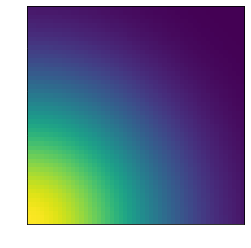

In [14]:
plt.imshow(precomp_GC[0][0:50,0:50]), 40*doubleJetCase_args["dx"] 

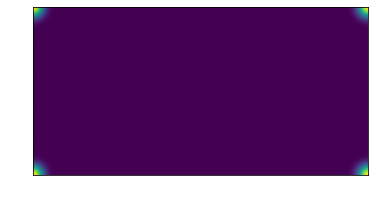

In [15]:
plt.imshow(precomp_GC[0])

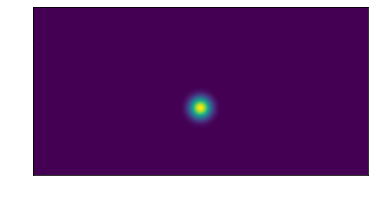

In [16]:
plt.imshow(precomp_GC[27])

In [17]:
N_y = len(obs_xs)

# Assembling observation distance matrix
obs_dist_mat = np.zeros((N_y, N_y))
for i in range(N_y):
    for j in range(N_y):
        dx = np.abs(obs_xs[i] - obs_xs[j])
        if dx > xdim/2:
            dx = xdim - dx
        dy = np.abs(obs_ys[i] - obs_ys[j])
        if dy > ydim/2:
            dy = ydim - dy 
        obs_dist_mat[i,j] = np.sqrt(dx**2+dy**2)
# Heavy diagonal such that 0-distances are above every threshold
np.fill_diagonal(obs_dist_mat, np.sqrt(xdim**2 + ydim**2))


In [18]:

# Groups of "un-correlated" observation
groups = list([list(np.arange(N_y, dtype=int))])
# Observations are assumed to be uncorrelated, if distance bigger than threshold
threshold = 2.0 * 1.5 * r

g = 0 
while obs_dist_mat[np.ix_(groups[g],groups[g])].min() < threshold:
    while obs_dist_mat[np.ix_(groups[g],groups[g])].min() < threshold:
        mask = np.ix_(groups[g],groups[g])
        idx2move = groups[g][np.where(obs_dist_mat[mask] == obs_dist_mat[mask].min())[1][0]]
        groups[g] = list(np.delete(groups[g], np.where(groups[g] == idx2move)))
        if len(groups)<g+2: 
            groups.append([idx2move])
        else:
            groups[g+1].append(idx2move)
    g = g + 1 

In [19]:
groups

[[0, 2, 6, 8, 10, 12, 16, 18, 20, 22, 26, 28, 30, 32, 36, 38, 40, 42, 46, 48],
 [1, 4, 5, 45, 7, 47, 11, 13, 15, 17, 21, 23, 25, 27, 31, 33, 35, 37, 41, 43],
 [3, 9, 49, 19, 29, 39],
 [14, 44, 24, 34]]

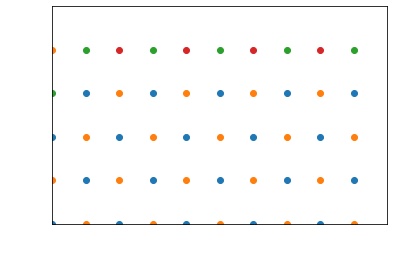

In [20]:
fig, ax = plt.subplots(1,1)
ax.set_xlim((0, xdim))
ax.set_ylim((0, ydim))

for g_idx, group in enumerate(groups):
    for o in group:
        ax.scatter(obs_xs[o], obs_ys[o], c="C"+str(g_idx))


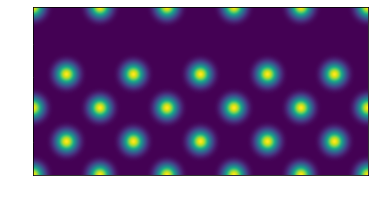

In [21]:
plt.imshow(np.sum(np.array(precomp_GC)[groups[0]], axis=0))

Generate observations

In [22]:
truth = CDKLM16.CDKLM16(**doubleJetCase_args, **doubleJetCase_init)
truth.updateDt()
truth.setKLModelError(**doubleJetCase_meargs)
truth.model_time_step = sim_model_error_time_step

# truth.dataAssimilationStep(6*60*60)

In [23]:
true_eta, true_hu, true_hv = truth.download(interior_domain_only=True)

obses = np.zeros((len(obs_xs),3))
for h, [obs_x, obs_y] in enumerate(zip(obs_xs, obs_ys)):
    Hx, Hy = SLobsCoord2obsIdx([truth], obs_x, obs_y)
    obses[h] = [true_eta[Hy,Hx], true_hu[Hy,Hx], true_hv[Hy,Hx]] + np.random.normal(0,R)


SL DA

In [24]:
SL_prior = copy.deepcopy(SLdownload(SL_ensemble))

In [26]:
SL_state = SLdownload(SL_ensemble)

for h, [obs_x, obs_y] in enumerate(zip(obs_xs, obs_ys)):
    print(h)
    SL_state = SLEnKF(SL_state, obses[h], obs_x, obs_y, R, obs_var, 
                        relax_factor=relax_factor, localisation_weights=precomp_GC[h],
                        dx=SL_ensemble[0].dx, dy=SL_ensemble[0].dy)
    
SLupload(SL_ensemble, SL_state)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [27]:
SL_posterior = copy.deepcopy(SLdownload(SL_ensemble))

In [28]:
from utils.DoubleJetPlot import *

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

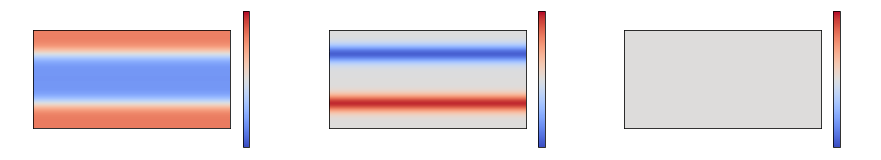

In [29]:
imshow3(SLestimate(SL_ensemble, np.mean), eta_vlim=3.5, huv_vlim=750)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

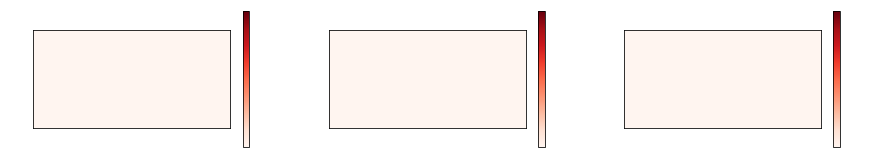

In [30]:
imshow3var(SLestimate(SL_ensemble, np.std), eta_vlim=0.5, huv_vlim=100)